In [ ]:
# Bibliotecas Gerais
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import warnings
import numpy as np
from numpy import array
from importlib import reload
from sklearn.naive_bayes import GaussianNB
import pickle


warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 227

In [ ]:
# Bibliotecas para Construção do Modelo
import tensorflow.keras as keras
from tensorflow.python.keras.optimizer_v2 import rmsprop
from functools import partial
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, TimeDistributed, LSTM, Dense, Bidirectional, Dropout, ConvLSTM2D, Conv1D, GlobalMaxPooling1D, MaxPooling1D, Convolution1D, BatchNormalization, LeakyReLU
from tensorflow.keras.utils import plot_model

In [ ]:
# Pacotes Customizados
import functions
import plotting

In [ ]:
np.random.seed(777)

In [ ]:
df = pd.read_parquet('data/eth.parquet')
df.shape

(294536, 20)

In [ ]:
n_steps = 21
scaled_eth = functions.scale(df, scale=(0,1))

x_train, y_train, x_test, y_test = functions.split_sequences(                    
    scaled_eth.to_numpy()[:-1], 
    df[['target']].shift(-1).to_numpy()[:-1], 
    n_steps, 
    split=True, 
    ratio=0.8
)

In [ ]:
n_steps = x_train.shape[1]
n_features = x_train.shape[2]

model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu', return_sequences=False))
model.add(Dense(10))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 21, 100)           48400     
_________________________________________________________________
lstm_9 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dense_8 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 11        
Total params: 79,121
Trainable params: 79,121
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(x_train, y_train, epochs=50, verbose=1, validation_data=(x_test, y_test), use_multiprocessing=True)

Epoch 1/50
7363/7363 [==============================] - 142s 19ms/step - loss: 0.1583 - mae: 0.2545 - val_loss: 0.0376 - val_mae: 0.1389
Epoch 2/50
7363/7363 [==============================] - 137s 19ms/step - loss: 0.0563 - mae: 0.1570 - val_loss: 0.0177 - val_mae: 0.0971
Epoch 3/50
7363/7363 [==============================] - 135s 18ms/step - loss: 0.0427 - mae: 0.1367 - val_loss: 0.0217 - val_mae: 0.1119
Epoch 4/50
7363/7363 [==============================] - 136s 19ms/step - loss: 0.0365 - mae: 0.1261 - val_loss: 0.0141 - val_mae: 0.0871
Epoch 5/50
7363/7363 [==============================] - 142s 19ms/step - loss: 0.0330 - mae: 0.1197 - val_loss: 0.0235 - val_mae: 0.1082
Epoch 6/50
7363/7363 [==============================] - 108s 15ms/step - loss: 0.0300 - mae: 0.1142 - val_loss: 0.0187 - val_mae: 0.1097
Epoch 7/50
7363/7363 [==============================] - 111s 15ms/step - loss: 0.0275 - mae: 0.1101 - val_loss: 0.0257 - val_mae: 0.1354
Epoch 8/50
7363/7363 [===================

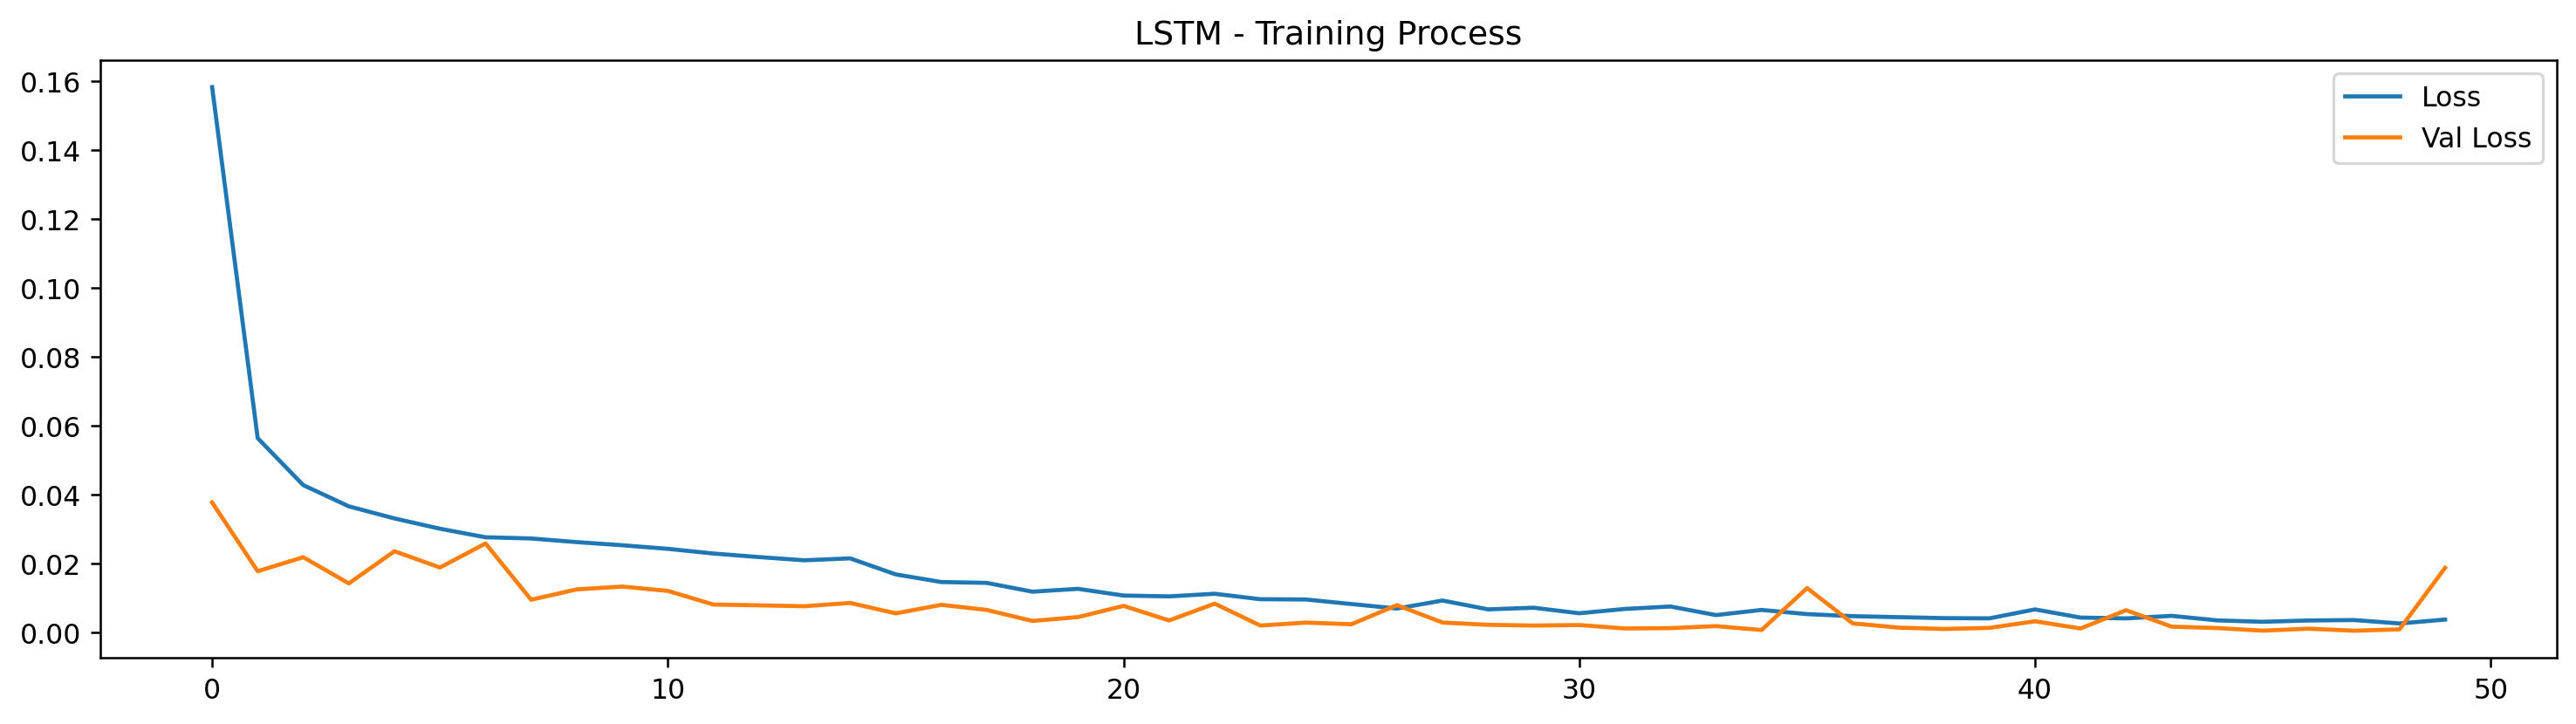

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(model.history.history['loss'], label='Loss')
plt.plot(model.history.history['val_loss'], label='Val Loss')
plt.legend(loc=1)
plt.title('LSTM - Training Process')
plt.show()

In [ ]:
pred, y_true, y_pred = functions.evaluation(
                    x_test, y_test, model, random=False, n_preds=50, 
                    show_graph=False)

MSE: 0.006834633659708714
Accuracy: 76%


In [ ]:
# Salvando o modelo em um arquivo pickle para ser utilizado nas etapas seguintes
filename = 'model_LSTM.pickle'
pickle.dump(model, open(filename, 'wb'))